In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
from tensorflow.keras.optimizers import Ftrl
from tensorflow.keras.callbacks import TensorBoard
import time
import tensorflow_addons as tfa

2024-04-18 16:48:49.178027: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 16:48:49.626372: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/jupyter-jphuser/.local/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependenci

In [2]:
def generate_train_test_samples( hdf_path: str, target_columns: list, columns_to_drop: list,test_size: float):
        try:
            df = pd.read_hdf(hdf_path)
        except:
            df = pd.read_csv(hdf_path)
            
        y = df[target_columns].to_numpy()
        X = df.drop(columns= columns_to_drop).to_numpy()
        
        X_train , X_test , y_train , y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        X_train , X_val , y_train , y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


        return (X_train, y_train, X_test, y_test,X_val,y_val)

In [3]:
class SaveStatsCallback(tf.keras.callbacks.Callback):
    def __init__(self, file_name):
        super().__init__()
        self.file_name = "Logs/"+file_name
        self.start_time = None

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        with open(self.file_name, 'a') as f:
            f.write(f"Epoch {epoch + 1}:\n")
            for key, value in logs.items():
                f.write(f"{key}: {value}\n")

    def on_train_end(self, logs=None):
        total_time = time.time() - self.start_time
        with open(self.file_name, 'a') as f:
            f.write(f"Total training time: {total_time} seconds\n")

In [10]:
(X_train,
 y_train,
 X_test,
 y_test,
 X_validation,
 y_validation) = generate_train_test_samples("data/dados.h5", ["perf"],["perf", "active_options"], 0.2)

In [11]:
X_train.shape

(66644, 9467)

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(X_train.shape[1], activation=tf.keras.layers.ELU(), input_shape=(X_train.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(X_train.shape[1], activation=tf.keras.layers.ELU(), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(1)
])

2024-04-18 16:50:16.228444: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 16:50:17.474023: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22283 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:00:0a.0, compute capability: 8.6


In [7]:
#optimizer = Ftrl(learning_rate=0.001, learning_rate_power=-0.5, initial_accumulator_value=0.1, l1_regularization_strength=0.1, l2_regularization_strength=0.1)

In [8]:
adamw = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01)

In [9]:
model.compile(optimizer="adam", loss=tf.keras.losses.Huber(), metrics=[tf.keras.losses.Huber(),tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.MeanAbsolutePercentageError()])

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [11]:
start = time.time()
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_test, y_test), callbacks=[early_stopping, SaveStatsCallback("result_smooth")])
end = time.time()

Epoch 1/500
  10/2083 [..............................] - ETA: 35s - loss: 52553004.0000 - huber_loss: 52552820.0000 - mean_squared_error: 7823522374090752.0000 - mean_absolute_percentage_error: 99.9696

2024-04-16 17:55:10.082025: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2083/2083 [==============================] - 42s 20ms/step - loss: 20595724.0000 - huber_loss: 20564372.0000 - mean_squared_error: 4638471801012224.0000 - mean_absolute_percentage_error: 23.5898 - val_loss: 16584132.0000 - val_huber_loss: 16522180.0000 - val_mean_squared_error: 3742354791989248.0000 - val_mean_absolute_percentage_error: 19.5483
Epoch 2/500
2083/2083 [==============================] - 38s 18ms/step - loss: 15502146.0000 - huber_loss: 15440906.0000 - mean_squared_error: 3644360818163712.0000 - mean_absolute_percentage_error: 17.6142 - val_loss: 14954058.0000 - val_huber_loss: 14882657.0000 - val_mean_squared_error: 3383274051207168.0000 - val_mean_absolute_percentage_error: 17.2438
Epoch 3/500
2083/2083 [==============================] - 39s 19ms/step - loss: 14551765.0000 - huber_loss: 14484146.0000 - mean_squared_error: 3399660156747776.0000 - mean_absolute_percentage_error: 16.5344 - val_loss: 14314364.0000 - val_huber_loss: 14238298.0000 - val_mean_squared_error: 323

Epoch 24/500
2083/2083 [==============================] - 39s 19ms/step - loss: 6558593.0000 - huber_loss: 6379251.0000 - mean_squared_error: 1061029593219072.0000 - mean_absolute_percentage_error: 7.6063 - val_loss: 8411003.0000 - val_huber_loss: 8227721.5000 - val_mean_squared_error: 1261731737239552.0000 - val_mean_absolute_percentage_error: 9.8607
Epoch 25/500
2083/2083 [==============================] - 39s 19ms/step - loss: 6212617.5000 - huber_loss: 6027664.5000 - mean_squared_error: 968815840067584.0000 - mean_absolute_percentage_error: 7.2708 - val_loss: 7838090.5000 - val_huber_loss: 7650068.0000 - val_mean_squared_error: 1091437357694976.0000 - val_mean_absolute_percentage_error: 9.1826
Epoch 26/500
2083/2083 [==============================] - 38s 18ms/step - loss: 5970801.5000 - huber_loss: 5779636.5000 - mean_squared_error: 876267884773376.0000 - mean_absolute_percentage_error: 7.1264 - val_loss: 8207077.0000 - val_huber_loss: 8015585.5000 - val_mean_squared_error: 9908363

In [12]:
print(end - start)

2610.4540214538574


In [14]:
import matplotlib.pyplot as plt

579/579 [==============================] - 2s 3ms/step


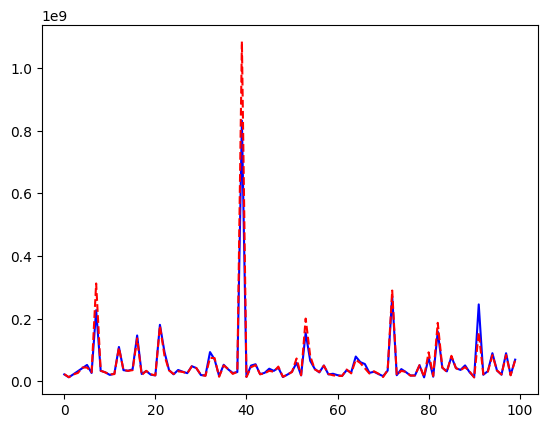

In [17]:
pred = model.predict(X_test)
plt.plot(pred[:100], color='b')
plt.plot(y_test[:100], color = 'r', linestyle = 'dashed')
plt.savefig("tensorflow_prediction_best_model.png", dpi=500)

## Teste com feature selection

In [1]:
import pandas as pd
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
from tensorflow.keras.optimizers import Ftrl
from tensorflow.keras.callbacks import TensorBoard
import time
rank = "..//results//feature_importance_DT.csv"
pd.read_csv(rank)

2024-04-19 14:22:34.432249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 14:22:34.560572: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


,Unnamed: 0,features,importance
0,0,DEBUG_INFO,0.329945
1,1,active_options,0.194352
2,2,X86_NEED_RELOCS,0.113563
3,3,DEBUG_INFO_REDUCED,0.112219
4,4,DEBUG_INFO_SPLIT,0.084252
...,...,...,...
9463,9463,HVC_XEN_FRONTEND,0.000000
9464,9464,ATM_ENI_DEBUG,0.000000
9465,9465,NEED_NODE_MEMMAP_SIZE,0.000000
9466,9466,ARCH_FLATMEM_ENABLE,0.000000


In [2]:
def generate_train_test_samples2( df: pd.DataFrame, target_columns: list, features_list: list, device: str = 'cuda',
                                 test_size: float = 0.2):
            
        y = df[target_columns].to_numpy()
        
        X = df[features_list].to_numpy()
        
        X_train , X_test , y_train , y_test = train_test_split(X, y, test_size=test_size, random_state=42)

        X_train , X_test , y_train , y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        X_train , X_val , y_train , y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
        
        return (X_train, y_train, X_test, y_test,X_val,y_val)

In [3]:
percentages =[0.9,0.8,0.7,0.5,0.3,0.1]
fiels = os.listdir("..//results//")
files = fiels[:-1]

In [4]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(9468, activation=tf.keras.layers.ELU(), input_shape=(9468,), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(9468, activation=tf.keras.layers.ELU(), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.0),
    tf.keras.layers.Dense(1)
])

2024-04-19 14:22:36.431835: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 14:22:37.058798: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22283 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:00:0a.0, compute capability: 8.6


In [6]:
model.compile(optimizer="adam", loss=tf.keras.losses.Huber(), metrics=[tf.keras.losses.Huber(),tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.MeanAbsolutePercentageError()])

In [7]:
files

['feature_importance_GB.csv',
 'feature_importance_DT.csv',
 'feature_importance_RF.csv']

In [8]:
def train_model_for_all_features(files: list[str], percentages: list[int]):
    with open("feature_selection_experimente_tensorflow.csv", "w") as f: 
        df = pd.read_hdf("data/dados.h5")
        for file in files:
            name = file.split("_")
            rank = pd.read_csv(f"..//results//{file}")
            for percentage in percentages:
                cut = rank['importance'].quantile(percentage)
                top_percent = rank[rank['importance'] >= cut]["features"]
                number_of_features = len(top_percent)
                data = generate_train_test_samples2(df,["perf"],top_percent)
                start = time.time()
                history = model.fit(data[0],data[1], epochs=500, validation_data=(data[2], data[3]), callbacks=[early_stopping])
                end = time.time()
                
                f.write(f"feature selection {file}")
                f.write(f"percentage {1 - percentage}")
                f.write(f"time to conclusion {end - start}")
                f.write(f"final loss {history.history['loss'][-1]}")

In [ ]:
train_model_for_all_features(files, percentages)

Epoch 1/500
   7/2083 [..............................] - ETA: 37s - loss: 41677192.0000 - huber_loss: 41677028.0000 - mean_squared_error: 3024320817266688.0000 - mean_absolute_percentage_error: 99.9301    

2024-04-19 14:23:42.067794: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2083/2083 [==============================] - 44s 20ms/step - loss: 23147076.0000 - huber_loss: 23138574.0000 - mean_squared_error: 5113292246745088.0000 - mean_absolute_percentage_error: 26.2254 - val_loss: 20938320.0000 - val_huber_loss: 20917166.0000 - val_mean_squared_error: 4687063987257344.0000 - val_mean_absolute_percentage_error: 22.5829
Epoch 2/500
2083/2083 [==============================] - 39s 19ms/step - loss: 17124460.0000 - huber_loss: 17091146.0000 - mean_squared_error: 4030082435776512.0000 - mean_absolute_percentage_error: 18.1296 - val_loss: 15591685.0000 - val_huber_loss: 15530398.0000 - val_mean_squared_error: 3494872065507328.0000 - val_mean_absolute_percentage_error: 16.5181
Epoch 3/500
2083/2083 [==============================] - 39s 19ms/step - loss: 13333085.0000 - huber_loss: 13264233.0000 - mean_squared_error: 3094948064788480.0000 - mean_absolute_percentage_error: 13.4213 - val_loss: 12985362.0000 - val_huber_loss: 12900404.0000 - val_mean_squared_error: 290

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
model.compile(optimizer="adam", loss=tf.keras.losses.Huber(), metrics=[tf.keras.losses.Huber(),tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.MeanAbsolutePercentageError()])